# The Battle of Neighborhoods - The next location to open a veterinary clinic in Singapore
- Author: Wang Zejia
- Date updated: 2020/11/16

In [106]:
import pandas as pd
import numpy as np

import folium # map rendering library
import requests # library to handle requests
# from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors

In [8]:
# foursquare credentials (removed for privacy reason)
CLIENT_ID = ''
CLIENT_SECRET = ''
VERSION = '20201101'

## 1. Data Collection

### 1.1 Location data of Singapore MRT stations
- Source: https://www.kaggle.com/yxlee245/singapore-train-station-coordinates
- Description: List of Singapore MRT stations with latitude and longitude

In [9]:
mrt_df = pd.read_csv('sg_mrt_data.csv')
print("The Singapore MRT dataset contains {} rows and {} columns".format(mrt_df.shape[0], mrt_df.shape[1]))
mrt_df.head()

The dataset contains 157 rows and 4 columns


,station_name,type,lat,lng
0,Jurong East,MRT,1.333207,103.742308
1,Bukit Batok,MRT,1.349069,103.749596
2,Bukit Gombak,MRT,1.359043,103.751863
3,Choa Chu Kang,MRT,1.385417,103.744316
4,Yew Tee,MRT,1.397383,103.747523


In [7]:
# check if the dataset contains null value
mrt_df.isnull().sum()

station_name    0
type            0
lat             0
lng             0
dtype: int64

### 1.2 Obtain veterinary clinics venues near each MRT station
- Source: Foursquare API https://developer.foursquare.com/docs/api-reference/venues/search/
- Description: The list of veterinary clinics venues within 2km of each MRT station

In [48]:
# function to obtain veterinary clinic venues near each mrt station

category_id = '4d954af4a243a5684765b473' # veterinarian: https://developer.foursquare.com/docs/build-with-foursquare/categories/

def getVetVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            category_id
        )
            
        # make the GET request
        results = requests.get(url).json()
        
        # if the request is successful, return and store relevant information for each nearby venue
        if results['meta']['code']==200:
            venues_list.append([(
                name,
                lat,
                lng,
                v['id'],
                v['name'],
                v['location']['lat'], 
                v['location']['lng'],  
                v['location']['distance']) for v in results['response']['venues']])

    venues_df = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    venues_df.columns = [
        'station_name', 
        'station_lat', 
        'station_lng', 
        'vet_id', 
        'vet_name', 
        'vet_lat', 
        'vet_lng',
        'vet_distance'
    ]
    
    return(venues_df)

In [49]:
venues_df = getVetVenues(names=mrt_df['station_name'],latitudes=mrt_df['lat'],longitudes=mrt_df['lng'])
print("The dataset contains {} rows and {} columns".format(venues_df.shape[0], venues_df.shape[1]))
venues_df.head()

The dataset contains 559 rows and 8 columns


,station_name,station_lat,station_lng,vet_id,vet_name,vet_lat,vet_lng,vet_distance
0,Jurong East,1.333207,103.742308,4d89579b7139b1f7a335b4d4,Island Veterinary,1.339389,103.734316,1124
1,Jurong East,1.333207,103.742308,54549ac2498e22fa72234c5b,The Joyous Vet,1.326232,103.724836,2093
2,Jurong East,1.333207,103.742308,4de1f041ae60e7f3abe43f19,Singapore Veterinary Animal Clinic,1.343995,103.730574,1774
3,Bukit Batok,1.349069,103.749596,51091730e4b026ea03ad83fc,My Family Vet,1.349688,103.759894,1148
4,Bukit Batok,1.349069,103.749596,4d89579b7139b1f7a335b4d4,Island Veterinary,1.339389,103.734316,2013


### 1.3 Combine all datasets and calculate aggregated metrics of each MRT station

In [155]:
# join mrt_df with descriptive statistic of each station from venues_df
df = mrt_df.join(venues_df.groupby('station_name').vet_distance.describe(),on='station_name',how='left')
df.head()

,station_name,type,lat,lng,count,mean,std,min,25%,50%,75%,max
0,Jurong East,MRT,1.333207,103.742308,3.0,1663.666667,493.832293,1124.0,1449.0,1774.0,1933.5,2093.0
1,Bukit Batok,MRT,1.349069,103.749596,5.0,1492.600000,563.755976,972.0,1140.0,1148.0,2013.0,2190.0
2,Bukit Gombak,MRT,1.359043,103.751863,3.0,925.666667,753.241219,56.0,702.5,1349.0,1360.5,1372.0
3,Choa Chu Kang,MRT,1.385417,103.744316,1.0,1025.000000,NaN,1025.0,1025.0,1025.0,1025.0,1025.0
4,Yew Tee,MRT,1.397383,103.747523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [156]:
# remove irrelevant columns and rename
df = df.drop(columns=['type','std','25%','75%'],axis=1)
df.columns = [
        'station_name', 
        'station_lat', 
        'station_lng', 
        'vet_count', 
        'vet_mean_distance', 
        'vet_min_distance', 
        'vet_median_distance',
        'vet_max_distance'
    ]

In [161]:
# for stations without result in venues_df, fill vet_count with 0, fill distance with -2000
df.fillna(value={'vet_count':0},inplace=True)
df.fillna(-2000,inplace=True)

In [162]:
print("The final dataset contains {} rows and {} columns, with the following schema".format(df.shape[0], df.shape[1]))
df.head()

The final dataset contains 157 rows and 8 columns, with the following schema


,station_name,station_lat,station_lng,vet_count,vet_mean_distance,vet_min_distance,vet_median_distance,vet_max_distance
0,Jurong East,1.333207,103.742308,3.0,1663.666667,1124.0,1774.0,2093.0
1,Bukit Batok,1.349069,103.749596,5.0,1492.600000,972.0,1148.0,2190.0
2,Bukit Gombak,1.359043,103.751863,3.0,925.666667,56.0,1349.0,1372.0
3,Choa Chu Kang,1.385417,103.744316,1.0,1025.000000,1025.0,1025.0,1025.0
4,Yew Tee,1.397383,103.747523,0.0,-2000.000000,-2000.0,-2000.0,-2000.0


## 2. Exploratory Data Analysis

### 2.1 Visualize map of Singapore with MRT stations labelled

In [14]:
# Singapore coordinate: https://www.gps-coordinates.net/map/country/SG
map_sg = folium.Map(location=[1.3649170000000002,103.82287200000002], zoom_start=12)

# add markers to map
for lat, lng, station_name in zip(mrt_df['lat'], mrt_df['lng'], mrt_df['station_name']):
    label = station_name
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sg)  
    
map_sg

### 2.2 Top 10 stations by number of veterinary clinics nearby

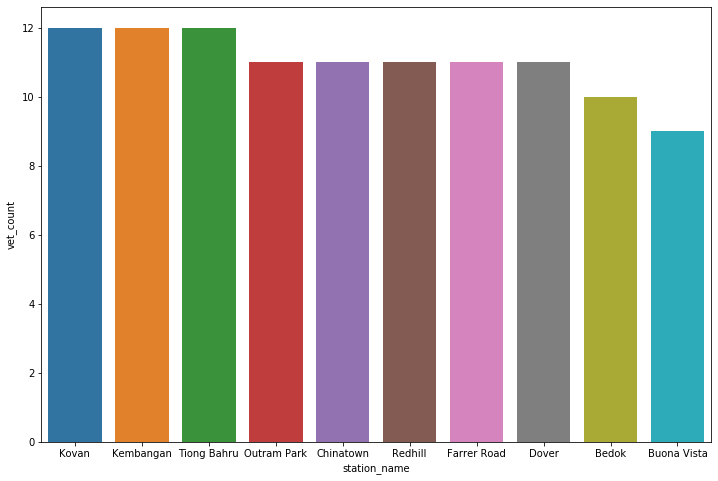

In [119]:
top_10_by_vet_count = df.sort_values(by='vet_count',ascending=False).head(10)
plt.figure(figsize=[12, 8])
sns.barplot(x=top_10_by_vet_count.station_name,y=top_10_by_vet_count.vet_count)

### 2.3 Top 10 stations by mean distance from veterinary clinics

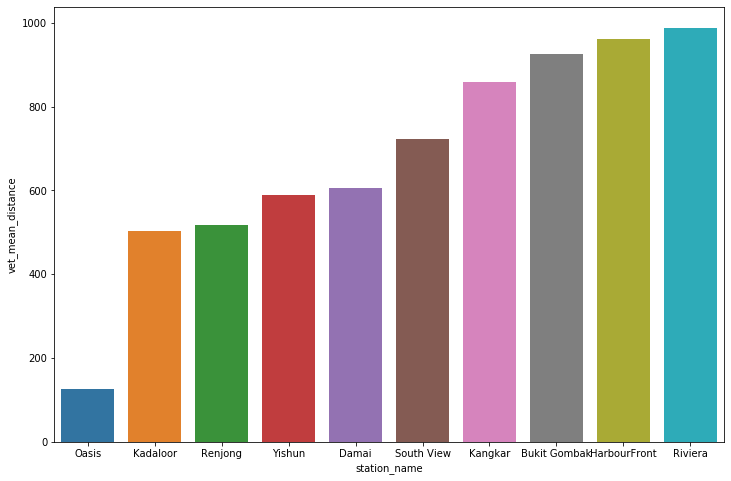

In [120]:
top_10_by_mean_distance = df.sort_values(by='vet_mean_distance',ascending=True).head(10)
plt.figure(figsize=[12, 8])
sns.barplot(x=top_10_by_mean_distance.station_name,y=top_10_by_mean_distance.vet_mean_distance)

## 3. Clustering (K-means)
- Description: Run k-means to cluster the MRT stations into 5 clusters
- Features: vet_count, vet_mean_distance, vet_min_distance, vet_median_distance, vet_max_distance

In [175]:
num_clusters = 5
X = df.values[:,3:]
k_means = KMeans(init = "k-means++", n_clusters = num_clusters, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
print(labels)

[3 3 0 4 1 4 3 3 3 2 4 0 3 0 3 0 0 0 3 3 3 2 2 3 2 1 1 1 2 2 1 2 3 0 0 0 0
 0 0 3 0 0 0 3 3 3 2 3 0 3 0 0 3 3 3 3 0 2 4 3 2 4 0 3 0 3 3 0 0 0 3 4 2 1
 1 2 2 2 3 3 3 0 2 3 0 0 0 0 0 3 2 1 2 3 2 1 2 2 0 0 0 0 0 3 3 2 2 2 3 3 3
 3 3 0 0 0 0 0 2 4 4 2 2 1 1 1 1 1 1 1 3 3 3 4 0 3 3 2 1 2 2 4 4 3 3 3 4 4
 4 4 4 3 2 2 2 2 2]


In [176]:
# add clustering labels to dataframe
df.drop(columns=['cluster_label'],inplace=True)
df.insert(0, 'cluster_label', labels)
df.head()

,cluster_label,station_name,station_lat,station_lng,vet_count,vet_mean_distance,vet_min_distance,vet_median_distance,vet_max_distance
0,3,Jurong East,1.333207,103.742308,3.0,1663.666667,1124.0,1774.0,2093.0
1,3,Bukit Batok,1.349069,103.749596,5.0,1492.600000,972.0,1148.0,2190.0
2,0,Bukit Gombak,1.359043,103.751863,3.0,925.666667,56.0,1349.0,1372.0
3,4,Choa Chu Kang,1.385417,103.744316,1.0,1025.000000,1025.0,1025.0,1025.0
4,1,Yew Tee,1.397383,103.747523,0.0,-2000.000000,-2000.0,-2000.0,-2000.0


## 4. Results and Discussion
- Characteristics of each cluster
    - Cluster 0: Most veterinary clicnis present (average count of 6.95) and easily accessible (average distance of 1.37km from the station)
    - Cluster 1: No veterinary clinic present within 2km from the station (average count of 0)
    - Cluster 2: Moderate number of veterinary clinics present (average count of 2.08) but least accessible (average distance of 1.98km from the station)
    - Cluster 3: Moderate number of veterinary clinics present (average count of 3.63) and moderately accessible (average distance of 1.58km from the station)
    - Cluster 4: Few veterinary clinics present (average count of 1.56) but most accessible (average distance of 859m from the station)
- Recommendation
    - The most desirable location to open a new veterinary clinic is in cluster 1, as there is currently no clinic nearby, which implies low competition and unmet demand
    - Second best location is in cluster 2, where existing veterinary clinics are least accessible. A new veterinary clinic nearer to the station would have competitive advantage over existing ones
    - The least desirable location is in cluster 0, where there are already sufficient clinics to meet the demand 

In [178]:
df.groupby('cluster_label')['vet_count','vet_mean_distance','vet_min_distance','vet_median_distance','vet_max_distance'].mean()

,vet_count,vet_mean_distance,vet_min_distance,vet_median_distance,vet_max_distance
cluster_label,,,,,
0,6.951220,1366.755788,478.487805,1399.134146,2154.780488
1,0.000000,-2000.000000,-2000.000000,-2000.000000,-2000.000000
2,2.088235,1979.222619,1836.852941,1992.470588,2089.705882
3,3.632653,1581.172811,1119.081633,1596.857143,1977.224490
4,1.562500,859.046875,841.625000,857.281250,884.687500


In [177]:
# create map
map_clusters = folium.Map(location=[1.3649170000000002,103.82287200000002], zoom_start=12)

# set color scheme for the clusters
x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df['station_lat'], df['station_lng'], df['station_name'], df['cluster_label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters